In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
weekly_price = pd.read_csv("Weekly_Price.csv")

In [3]:
#Initial Parameter
W = 1000000
K = 41
Vol = 0.5137
r = 0.01035
T = 20 #Weeks

In [4]:
def Black_Schole_Call(stock_price, K, Vol, r, T):
    if T > 0:
        d1 = (np.log(stock_price / K) + (r + 0.5 * (Vol**2)) * T) / (Vol * np.sqrt(T))
        d2 = d1 - Vol * np.sqrt(T)       
    else:  
        if stock_price >= K:
            d1 = 99999
            d2 = d1 - Vol * np.sqrt(T)
        else:
            d1 = -99999
            d2 = d1 - Vol * np.sqrt(T)
    Call = stock_price * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)
    return(Call)


def Delta(stock_price, K, Vol, r, T):   
    if T > 0:
        d1 = (np.log(stock_price / K) + (r + 0.5 * (Vol**2)) * T) / (Vol * np.sqrt(T))   
    else:   
        if stock_price >= K:
            d1 = 99999   
        else:
            d1 = -99999
    return(norm.cdf(d1))


def Calculate_Cost(data):
    data["Interest_expense"] = np.zeros(len(data))
    data["Cumulative_Cost"] = np.zeros(len(data))

    for i in range(len(data)):
        if i == 0:
            data["Cumulative_Cost"][i] = data["Cost_of_Share"][i]
            data["Interest_expense"][i] = data["Cumulative_Cost"][i] * (r * 1/52)
        else:
            data["Cumulative_Cost"][i] = data["Cumulative_Cost"][i - 1] + data["Cost_of_Share"][i] + data["Interest_expense"][i- 1]
            data["Interest_expense"][i] = data["Cumulative_Cost"][i] * (r * 1/52)
            
            
def Calculate_Profit(data):
    Total_Income = (data["Call_Price_BS"][0] * W * (1 + (r * T / 52)))
    
    if (data["Weekly_Price"][len(data) - 1]) >= K:
        Total_Cost = data.Cumulative_Cost[len(data) - 1] + data.Interest_expense[len(data) - 1] - (K * W)
    else:
        Total_Cost = data.Cumulative_Cost[len(data) - 1] + data.Interest_expense[len(data) - 1]
    
    Profit = Total_Income - Total_Cost
    return(Profit)


def Final_Result(K, Vol):
    weekly_price = pd.read_csv("Weekly_Price.csv")
    weekly_price["Expiration"] = pd.Series(range(T,  -1, -1)) / 52 #52 weeks == 1 year
    weekly_price["Call_Price_BS"] = weekly_price.apply(lambda x: Black_Schole_Call(x["Weekly_Price"], K, Vol, r, x["Expiration"]), axis = 1)
    weekly_price["Delta"] = weekly_price.apply(lambda x: Delta(x["Weekly_Price"], K, Vol, r, x["Expiration"]), axis = 1)
    weekly_price["Share_Netural"] = W * weekly_price["Delta"]
    weekly_price["Share_Purchased"] = weekly_price["Share_Netural"].diff(1)
    weekly_price["Share_Purchased"].values[0] = weekly_price["Share_Netural"][0]
    weekly_price["Cost_of_Share"] = weekly_price["Share_Purchased"] * weekly_price["Weekly_Price"]
    Calculate_Cost(weekly_price)
    return(Calculate_Profit(weekly_price))

In [5]:
# weekly_price["Expiration"] = pd.Series(range(T,  -1, -1)) / 52 #52 weeks == 1 year

# weekly_price["Call_Price_BS"] = weekly_price.apply(lambda x: Black_Schole_Call(x["Weekly_Price"], K, Vol, r, x["Expiration"]), axis = 1)
# weekly_price["Delta"] = weekly_price.apply(lambda x: Delta(x["Weekly_Price"], K, Vol, r, x["Expiration"]), axis = 1)
# weekly_price["Share_Netural"] = W * weekly_price["Delta"]

# weekly_price["Share_Purchased"] = weekly_price["Share_Netural"].diff(1)
# weekly_price["Share_Purchased"].values[0] = weekly_price["Share_Netural"][0]

# weekly_price["Cost_of_Share"] = weekly_price["Share_Purchased"] * weekly_price["Weekly_Price"]

#### Using apply to calculate...(still have problem to fix)

In [6]:
# K_Vol = pd.DataFrame()
# for K in np.arange(30, 50.5, 0.5):
#     for Vol in np.arange(0.05, 1.05, 0.05):
#         K_Vol_temp = pd.DataFrame([K, Vol])
#         K_Vol = pd.concat([K_Vol, K_Vol_temp], axis = 1)
        
# K_Vol = K_Vol.T
# K_Vol.columns = ["K", "Vol"]


# %%time
# Final_Profit = K_Vol.apply(lambda x: Final_Result(x["K"], x["Vol"]), axis = 1)
# Final = pd.concat([K_Vol, Final_Profit], axis = 1)

#### Using for loop to calculate

In [7]:
# %%time
# Final = pd.DataFrame()

# for K in np.arange(31, 51.5, 0.5):
#     for Vol in np.arange(0.05, 1.05, 0.05):
#         Final_temp = pd.DataFrame([K, Vol, Final_Result(K, Vol)])
#         Final = pd.concat([Final, Final_temp], axis = 1)
        
# Final = Final.T

### Ploting

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


Final = pd.read_csv("Final.csv")
Final = Final.iloc[:, 1:4]

In [9]:
print(max(Final.Profit), min(Final.Profit))

8382046.88822 -5676941.0949


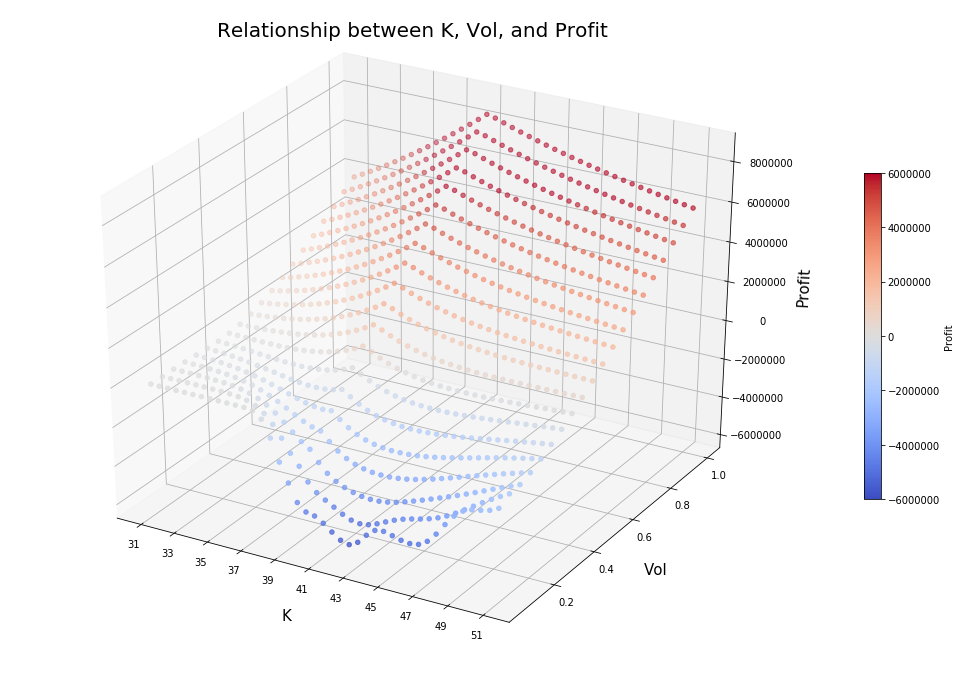

In [10]:
Final = pd.read_csv("Final.csv")

fig = plt.figure(figsize = (18,12))
ax = plt.axes(projection='3d')

X = Final.K.values
Y = Final.Vol.values
Z = Final.Profit.values
scatter = ax.scatter(X, Y, Z ,c = Z, cmap=cm.coolwarm,vmax=6000000, vmin=-6000000)

ax.set_ylabel("Vol", fontsize = 15, labelpad=15)
ax.set_xlabel("K", fontsize = 15, labelpad=15)
ax.set_zlabel("Profit", fontsize = 15, labelpad=28)

ax.tick_params(axis='z', which='major', pad=15)

plt.xticks(np.arange(31, 51.5, 2))

Title = plt.title("Relationship between K, Vol, and Profit", fontsize=20)
Title.set_y(0.95)

fig.colorbar(scatter, shrink=0.5, aspect=20, label = "Profit");

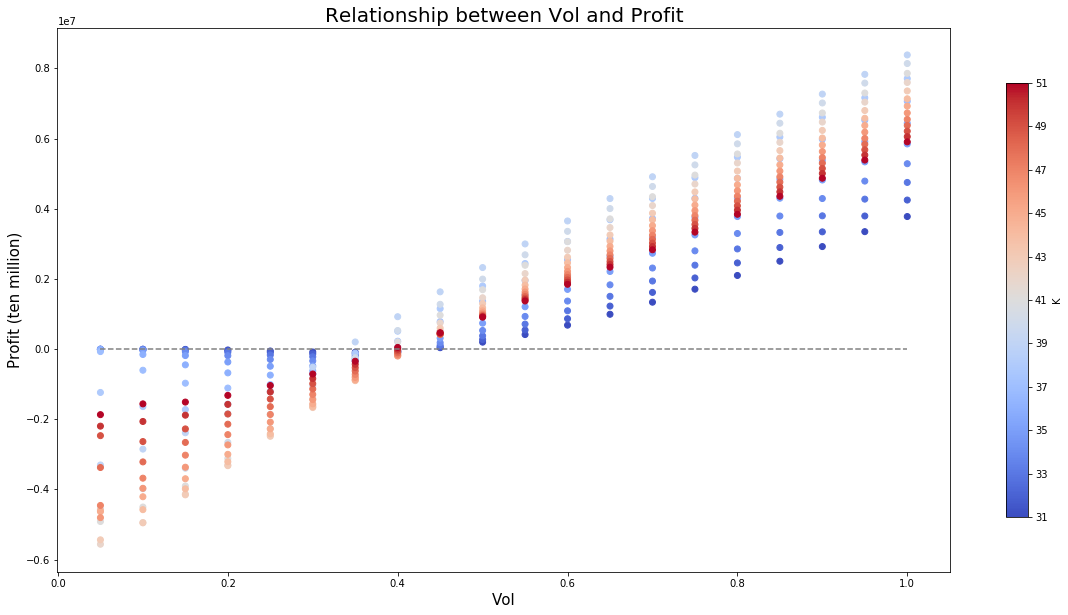

In [11]:
Final = pd.read_csv("Final.csv")
Final = Final.iloc[:, 1:4]
fig = plt.figure(figsize = (20, 10))

for K in np.arange(31, 51.5, 1):
    scatter = plt.scatter(Final[Final.K == K].Vol, Final[Final.K == K].Profit, label = K, cmap=cm.coolwarm, vmax=51, vmin=31, c = Final[Final.K == K].K)
    
cbar = fig.colorbar(scatter, shrink=0.8, aspect=20, label = "K")
cbar.set_ticks(np.arange(31, 51.5, 2))
plt.plot(np.arange(0.05, 1.05, 0.05), np.zeros(20), c = "grey", ls = "--")

plt.xlabel("Vol", fontsize=15)
plt.ylabel("Profit (ten million)", fontsize=15)
plt.title("Relationship between Vol and Profit", fontsize=20);

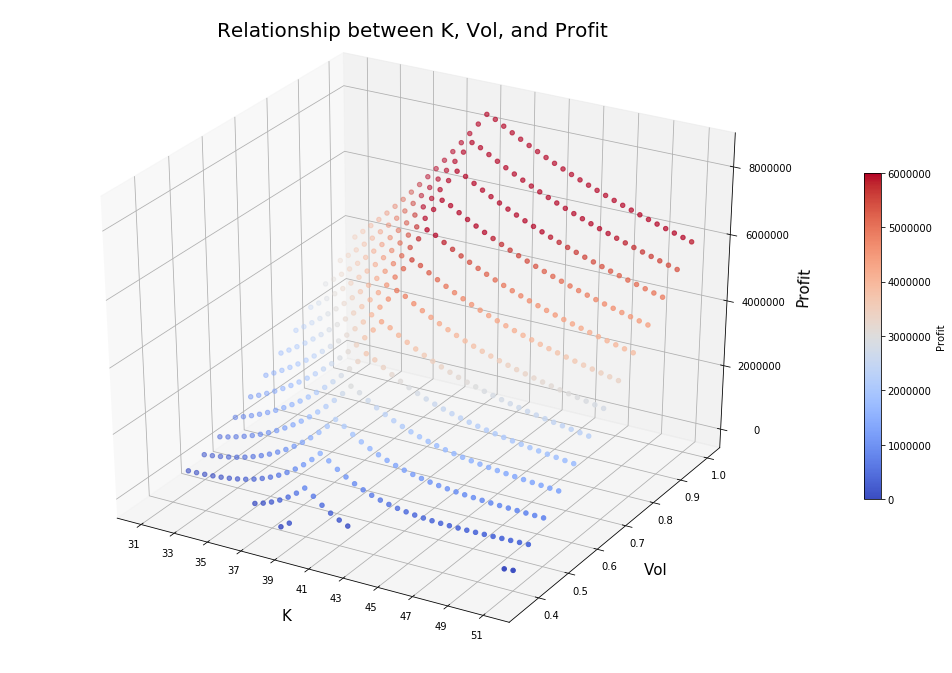

In [12]:
Final = pd.read_csv("Final.csv")
Final = Final.iloc[:, 1:4]
Final = Final[Final.Profit >=0 ]

fig = plt.figure(figsize = (18,12))
ax = plt.axes(projection='3d')

X = Final.K.values
Y = Final.Vol.values
Z = Final.iloc[:,2].values
scatter = ax.scatter(X, Y, Z ,c = Z, cmap=cm.coolwarm,vmax=6000000, vmin=0)

ax.set_ylabel("Vol", fontsize = 15, labelpad=15)
ax.set_xlabel("K", fontsize = 15, labelpad=15)
ax.set_zlabel("Profit", fontsize = 15, labelpad=28)

ax.tick_params(axis='z', which='major', pad=15)

plt.xticks(np.arange(31, 51.5, 2))

Title = plt.title("Relationship between K, Vol, and Profit", fontsize=20)
Title.set_y(0.95)

fig.colorbar(scatter, shrink=0.5, aspect=20, label = "Profit");

#### using multiprocessing to calculate...(still have problem to fix)

In [13]:
# from multiprocessing import cpu_count, Pool
# cores = cpu_count() 
# partitions = cores - 1

# def parallelize(data, func):
#     data_split = np.array_split(data, partitions)
#     pool = Pool(cores)
#     data = pd.concat(pool.map(func, data_split))
#     pool.close()
#     pool.join()
#     return data

# def Final_Result_Combine(data):
#     Final_Profit = data.apply(lambda x: Final_Result(x["K"], x["Vol"]), axis = 1)
#     return(Final_Profit)

# %%time
# Final_Profit2 = parallelize(test, Final_Result_Combine)